In [75]:
# Authors:

# Optimisation and Machine Learning for Process Systems Engineering:
# https://www.imperial.ac.uk/optimisation-and-machine-learning-for-process-engineering/about-us/



The first part of this notebook is a recap from the course. There is a practical section after this recap.

You will find <font color='blue'>text in blue for a few simple planned **coding tasks** that you can implement.</font>

Within the code cell, we suggest your implementation to be between the line:

`============= Start of your code =============`

and the line:

`============= End of your code =============` **bold text**

# Problem description

Summary of the general anomaly detection problem

* Anomaly data is scarce, therefore it is considered that we can only use normal operation data for training. The few instances of fault behavior we have are left for validation purposes
* Therefore, we face a semisupervised problem. We know the labels of normal instances only and we only feed the training with them. The distinction between both classes must be made *after* and not *during* training through some kind of threshold tuning.
* Typical methods used range from statistical, neural networks, distance-based (<font color='red'>summarize here more from time series analysis</font>)

# Warm-up: single variable example

In this example, we are generating temperature data from a reactor. We have two sets of data:

- The training set, which we are certain contains normal operation conditions (NOC) only
- The cross-validation set, which contains a mix of both normal and anomaly conditions

We will use statistical methods to try to predict the state of the system in the validation dataset

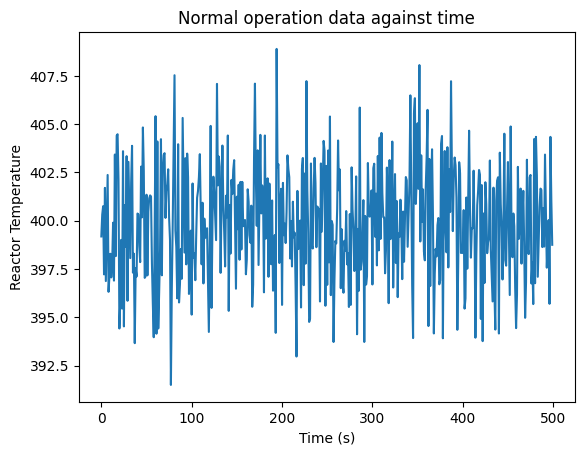

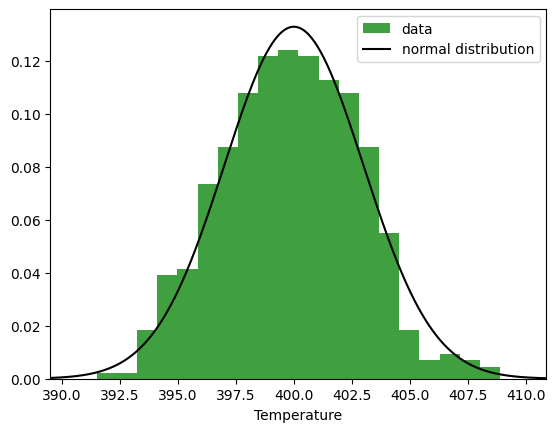

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
np.random.seed(41)

# Generate normal operation conditions (NOC) data
mean    = 400
std = 3
n_noc = 500

X_train = np.random.normal(mean, std, n_noc)

# Time-series plot
x = np.linspace(X_train.min() - 2, X_train.max() + 2, 1000)
plt.plot(X_train)
plt.title('Normal operation data against time')
plt.xlabel('Time (s)')
plt.ylabel('Reactor Temperature')
plt.show()

# Histogram
plt.hist(X_train, 20, density=True, facecolor='g', alpha=0.75, label='data')
plt.plot(x, scipy.stats.norm.pdf(x, mean, std), color='black', label='normal distribution')
plt.xlabel('Temperature')
plt.xlim(min(x), max(x))
plt.legend(loc='best')
plt.show()

We can select a specific threshold over which any value will be considered an anomaly. A typical one is $2\sigma$, which corresponds with about a 95 % confidence level

Note that, in real-life examples, we do not know the exact mean and standard deviation of our data. Therefore, the way to work with them is estimating the mean and standard deviation of our sample in the training set.

In [77]:
mean_train = X_train.mean()
std_est = X_train.std()
th_lower = mean_train - 2 * std_est
th_higher = mean_train + 2 * std_est

Text(0.5, 0, 'Temperature')

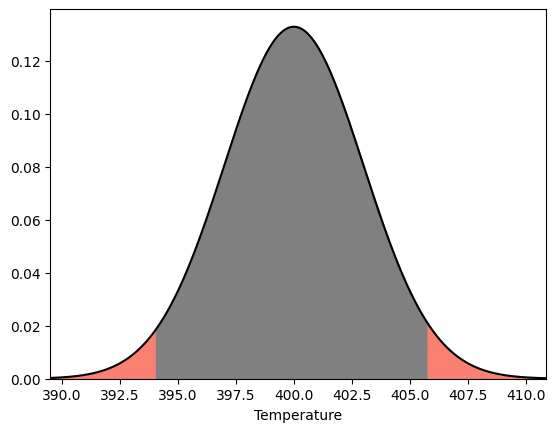

In [78]:
# Get NOC bounds
x_fill = np.linspace(th_lower, th_higher)
fig_pdf, ax_pdf = plt.subplots()
ax_pdf.plot(x, scipy.stats.norm.pdf(x, mean, std), color='black', label='normal distribution')
ax_pdf.fill_between(x_fill, scipy.stats.norm.pdf(x_fill, mean, std), color='grey')
# Get anomaly bounds
x_fault = np.linspace(min(x), th_lower)
ax_pdf.fill_between(x_fault, scipy.stats.norm.pdf(x_fault, mean, std), color='salmon')
x_fault = np.linspace(th_higher, max(x))
ax_pdf.fill_between(x_fault, scipy.stats.norm.pdf(x_fault, mean, std), color='salmon')
ax_pdf.set_xlim(min(x), max(x))
ax_pdf.set_ylim([0, None])
ax_pdf.set_xlabel('Temperature')

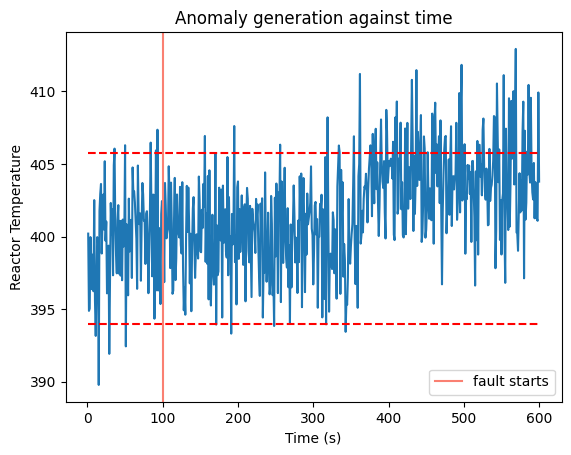

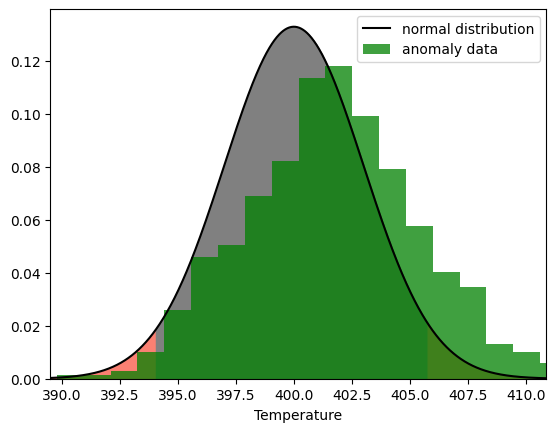

In [79]:
# Generate anomaly data with drift
n_noc = 100
n_fault_slice = 50  # 50 slices of 10 points each
n_slice = 10
changeRate = 1.01
X_test = np.random.normal(mean, std, n_noc)

poisson_variable = np.random.poisson(0.05, n_fault_slice);
mu_fault = mean
sigma_fault = std
for i in range(0, n_fault_slice):
    mu_fault = mu_fault * (changeRate ** poisson_variable[i])
    sigma_fault = sigma_fault * (changeRate ** poisson_variable[i])
    next_fault_data = np.random.normal(mu_fault, sigma_fault, n_slice)
    X_test = np.concatenate((X_test, next_fault_data))

# Time series plot
x_fault = np.arange(1, len(X_test) + 1)
plt.plot(x_fault, X_test)
plt.axvline(n_noc, color='salmon', label='fault starts')

plt.plot([x_fault[0], x_fault[-1]], [th_higher, th_higher], 'r--')
plt.plot([x_fault[0], x_fault[-1]], [th_lower, th_lower], 'r--')

plt.title('Anomaly generation against time')
plt.xlabel('Time (s)')
plt.ylabel('Reactor Temperature')
plt.legend(loc='best')
plt.show()

# Histogram
ax_pdf.hist(X_test, 20, density=True, facecolor='g', alpha=0.75, label='anomaly data')
ax_pdf.legend(loc='best')
fig_pdf

Let's obtain a metric for how well does this anomaly detector worked.

The obtained accuracy is 28.17 %


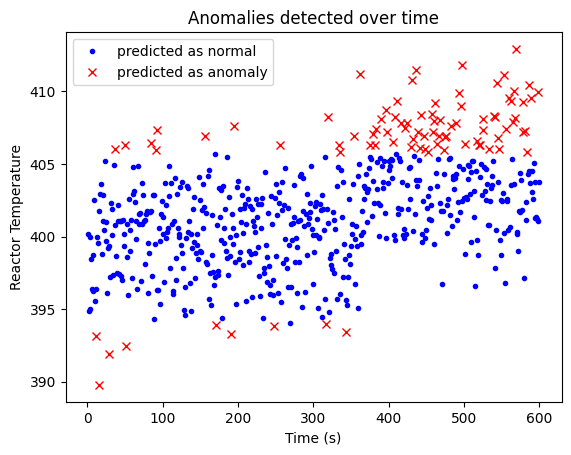

In [80]:
# First we get the actual labels of our cross-validation set
# We know that the first 100 instances are normal, while the fault starts
#  from that point onwards
y_true = np.concatenate((
    np.zeros((n_noc,)),
    np.ones((n_fault_slice * n_slice))
))
y_pred = (X_test > th_higher) | (X_test < th_lower)

# Plot our prediction
plt.plot(x_fault[y_pred == 0], X_test[y_pred == 0], 'b.', label='predicted as normal')
plt.plot(x_fault[y_pred == 1], X_test[y_pred == 1], 'rx', label='predicted as anomaly')
plt.title('Anomalies detected over time')
plt.xlabel('Time (s)')
plt.ylabel('Reactor Temperature')
plt.legend(loc='best')

# Use the accuracy_score function from skit-learn
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"The obtained accuracy is {accuracy * 100:0.2f} %")

Note that due to our threshold, a few false positives take place. This is a common trade-off in anomaly detection:
- **It is usually difficult to avoid both false positives and false negatives** at the same time
- The determination of the threshold is an important task that the engineer must take into account to give more weight to one or another.
- This depends heavily on the application: e.g. in medical applications, false positives are highly discouraged, while spam detection might be more indulgent in that sense

Also note that the fault takes quite a while to manifest, from it start at $t=100$ min to the first visually noticeable drift at aroun $t=300$ min. More advanced methods might help us anticipate this anomaly but, without more variables showing more hints, it can be impossible to increase our accuracy.

<font color = blue>Now, you will need to write code to detect the anomalies in this dataset fitting the data to a normal distribution and reporting the outliers using the overall accuracty as a metric.<\font>

To determine a threshold to distinguish normal from anomalous instances, use three times the standard deviation ($3\sigma$)

In [ ]:
# ============= Start of your code ============= #


# =============  End of your code  ============= #

<font color='blue'>Now tune this threshold using a numerical method to get a specific performance </font> (<font color='red'>not useful now since it can be demonstrated that a specific sigma leaves a specific % out of "normality". BUT will be useful for Autoencoders and PCA</font>) ?

## [Optional] repeat stacking time windows

# Multivariate example

Now, consider a more complex case where we have 10 variables that conform a dataset representative of the state of the system.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.metrics import accuracy_score
np.random.seed(41)

In [2]:
def generate_multivariate_normal_dataset(mean, covariance, n, perc_noc, changing_rate, rng=None, shuffle=False):
  n_noc = int (n * perc_noc)
  n_fault = n - n_noc

  x_noc = np.zeros((n_noc, 10))
  x_fault = np.zeros((n_fault, 10))

  # Generate data under normal conditions
  x_noc = rng.multivariate_normal(mean=mean, cov=covariance, size=n_noc)
  label_noc = np.zeros(n_noc)
  label_noc = label_noc.reshape((len(label_noc), 1))
  data_noc = np.concatenate((x_noc, label_noc), axis=1)

  # Generate data include fault
  poisson_generator = rng.poisson(0.2, n_fault)
  label_poisson = np.ones(n_fault)
  for j in range(n_fault):
    if poisson_generator[j] != 0:
        label_poisson[0:j+1] = 0
        break

  # Depends on whether mean or cov is changing
  mean_fault = mean
  cov_fault = covariance

  for i in range(x_fault.shape[0]):
    if poisson_generator[i] != 0:
        cov_fault[0,1] *= (1+changing_rate)**(poisson_generator[i]) # make it also accumulated(to detect as soon as possible)
        cov_fault[1,0] *= (1+changing_rate)**(poisson_generator[i])
    instance = rng.multivariate_normal(mean=mean_fault, cov=cov_fault, size=1)
    x_fault[i] = instance

  label_poisson = label_poisson.reshape((len(label_poisson), 1))
  data_fault = np.concatenate((x_fault, label_poisson), axis=1)

  data_np = np.concatenate((data_noc, data_fault), axis=0)
  data = pd.DataFrame(data_np, columns=['x1', 'x2', 'x3', 'x4','x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'label'])

  if shuffle == True:
    data.sample(frac=1).reset_index(drop=True)

  return data, data_np

In [7]:
# Generate data
n_samples = 500
perc_noc_train = 1   # % NOC instances in the training set (100 %)
perc_noc_test = 0.2  # % NOC instances in the test set (100 %)
changing_rate = 0.15
base_rng      = np.random.default_rng(42)

# Generate means
mean = base_rng.integers(low=1, high=10, size=10)
print(mean)

# Generate covariance
covariance = np.array([[2.0, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5],
                      [-0.5, 2.0, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5],
                      [0.5, -0.5, 2.0, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5],
                      [-0.5, 0.5, -0.5, 2.0, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5],
                      [0.5, -0.5, 0.5, -0.5, 2.0, -0.5, 0.5, -0.5, 0.5, -0.5],
                      [-0.5, 0.5, -0.5, 0.5, -0.5, 2.0, -0.5, 0.5, -0.5, 0.5],
                      [0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 2.0, -0.5, 0.5, -0.5],
                      [-0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 2.0, -0.5, 0.5],
                      [0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 2.0, -0.5],
                      [-0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 2.0]])
print(covariance)


data_train, data_train_np = generate_multivariate_normal_dataset(mean, covariance, n_samples, perc_noc_train, changing_rate, rng=base_rng, shuffle=False)
data_test, data_test_np = generate_multivariate_normal_dataset(mean, covariance, n_samples, perc_noc_test, changing_rate, rng=base_rng, shuffle=False)
X_train = data_train.drop(['label'], axis=1).to_numpy()
y_train = data_train['label'].to_numpy()
X_test = data_test.drop(['label'], axis=1).to_numpy()
y_test = data_test['label'].to_numpy()

# The features of the dataset correspond to the columns of X_train
n_features = X_train.shape[1]

[1 7 6 4 4 8 1 7 2 1]
[[ 2.  -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5]
 [-0.5  2.  -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5]
 [ 0.5 -0.5  2.  -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5]
 [-0.5  0.5 -0.5  2.  -0.5  0.5 -0.5  0.5 -0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5  2.  -0.5  0.5 -0.5  0.5 -0.5]
 [-0.5  0.5 -0.5  0.5 -0.5  2.  -0.5  0.5 -0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5  0.5 -0.5  2.  -0.5  0.5 -0.5]
 [-0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  2.  -0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  2.  -0.5]
 [-0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  2. ]]


/tmp/ipykernel_11239/519892136.py:30: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  instance = rng.multivariate_normal(mean=mean_fault, cov=cov_fault, size=1)


In [8]:
X_train

array([[ 0.09868644,  7.94632878,  4.30928711, ...,  7.36799673,
         1.32845854,  1.80352378],
       [ 0.73566596,  7.23889273,  5.09914447, ...,  6.9541982 ,
         2.00865176,  3.13479152],
       [ 1.33458824,  7.07694039,  4.94890021, ...,  8.7596452 ,
         3.85999069,  1.10797869],
       ...,
       [ 0.67214832,  7.12058213,  6.12339801, ...,  6.41944099,
         0.97129578,  0.66664527],
       [ 1.79130202,  6.59061002,  6.42547469, ...,  7.31735257,
         0.60111255,  0.35899691],
       [ 1.46986382,  6.67132344,  6.30310025, ...,  5.69207294,
         2.46721929, -1.21710037]])

In this case, the dataset is completly random, and disturbances are introduced in the covariance between the first and second variable, which starts suffering a drift based on a Poisson disturbance like in the single-variable example

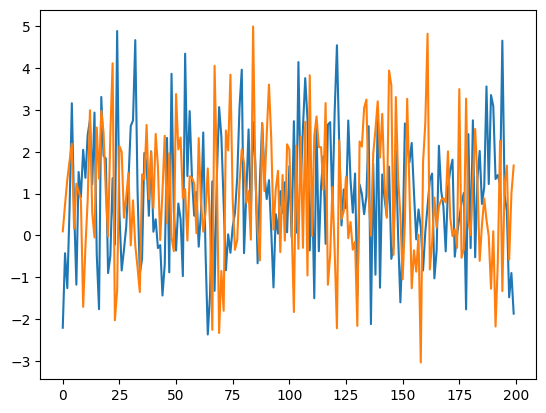

In [9]:
plt.plot(data_test.iloc[:200,0])
plt.plot(data_train.iloc[:200,0])

## Dealing with each variable separately

We estimate the detection thresholds for each variable separately. For this, we use the probability density function of the normal distribution

$f(x_i|\mu, \sigma^2) = \frac{1}{{\sqrt{2 \pi \sigma^2}}} e^{-\frac{{(x - \mu)^2}}{{2 \sigma^2}}}$

XXXXXXXXXXXXXXXX Note that the probability density function is not exactly yielding probabilites, but a measure of the density of the random distribution at a specific point. however, it serves as a way to determine how frequent a range of values are  

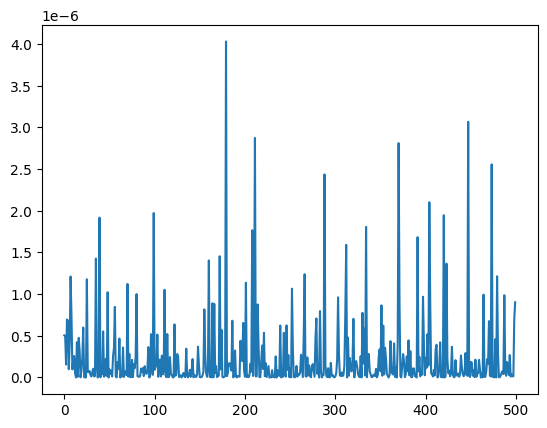

In [40]:
def probability_density(X, mean, var):
    """
    Calculate the probability density of a series of instances in X given the
    multivariate mean and covariance matrix.
    """
    n = len(mean)
    
    if var.ndim == 1:
        var = np.diag(var)
        
    X = X - mean
    p = (2 * np.pi)**(- n/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    
    return p

Now we estimate the means and covariance of our system using the training set

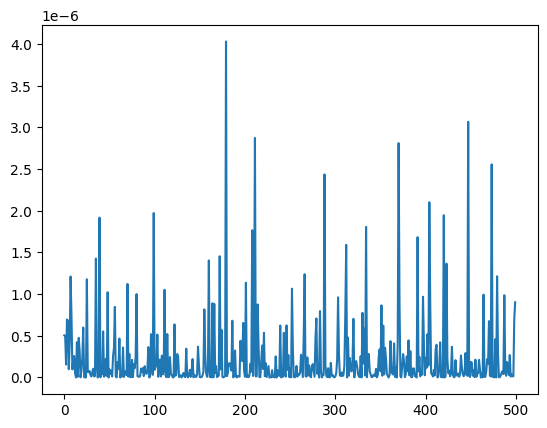

In [43]:
# Estimate Gaussian distribution
mean_train = np.mean(X_train, axis=0)
cov_train = np.cov(X_train, rowvar=False)  # By default it treats each row as a variable


Fit the threshold using the training set

In [67]:
def get_threshold(X, y, mean, cov, target_acc=0.95):
    # Get probabilities
    probs = probability_density(X, mean, cov)
    # Get extremes of p
    p_range = np.linspace(probs.min(), probs.max(), int(1e6))
    # Loop them until finding the closer value to 99 % accuracy (brute force)
    error_old = 1
    accs = []
    for p in p_range:
        # Obtain predictions given the current threshold
        y_pred = probs < p
        # Calculate accuracy and measure the error with respect target_acc
        acc = accuracy_score(y, y_pred)
        accs.append(acc)
        error = (target_acc - acc) ** 2
        # print(f"Obtained accuracy {acc}, error {error}")
        if error < error_old:
            threshold = p 
            error_old = error
        elif error > error_old:
            # Avoid continuing since no better error will be obtained
            break
    plt.plot(accs)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    return threshold

Error will no longer improve


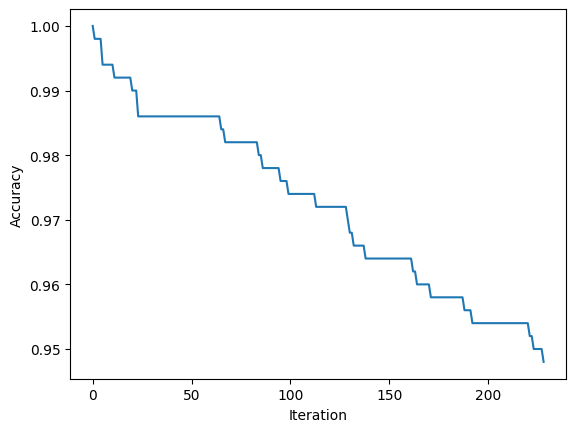

In [68]:

threshold = get_threshold(X_train, y_train, mean_train, cov_train)

Check we obtain the desired accuracy

In [72]:

y_train_pred = probability_density(X_train, mean_train, cov_train) < threshold
print(f'We should have {int(len(X_train) * 0.05)} false positives.')
print(f'We have {sum(y_train_pred)} false positives')

We should have 25 false positives.
We have 25


Now that we have our threshold, we can evaluate test set. Remember we use the fitted mean and variance from the training set, we do not obtain these from the test set.

In [74]:
p_test = probability_density(X_test, mean_train, cov_train) 
y_test_pred = p_test < threshold
acc_test = accuracy_score(y_test, y_test_pred)
print(f'The obtained accuracy is {acc_test *100} %')

The obtained accuracy is 73.6 %


Take into account that, this time, the data is multidimensional. One simple approach here is to apply the single variable random distribution to each feature of the dataset, and compound their effect into a single probability:

$p_{\text{XMEAS}(1)} · p_{\text{XMEAS}(2)} · ... · p_{\text{XMEAS}(22)} $

Take into account that this approach is a simplification and assumes each feature is statisticallly independent from each other. Later we will try to improve this.

## A multivariate approach

# The Tennessee Eastman problem

The Tennessee Eastman (TE) process is a virtual plant that Downs and Vogel designed based on an Eastman Chemical Company process [7]. In this virtual plant, a series of reactants, A, C, D, and E are processed to obtain two products, G and H, as pure as possible, with an unavoidable inert component mixed in the feed, B, and a byproduct, F. To obtain the desired products, the system is made up of five unit operations: a reactor, a condenser, a liquid-vapor phase separator, a compressor, and a stripper column. The next figure shows a process flow diagram of the complete system.



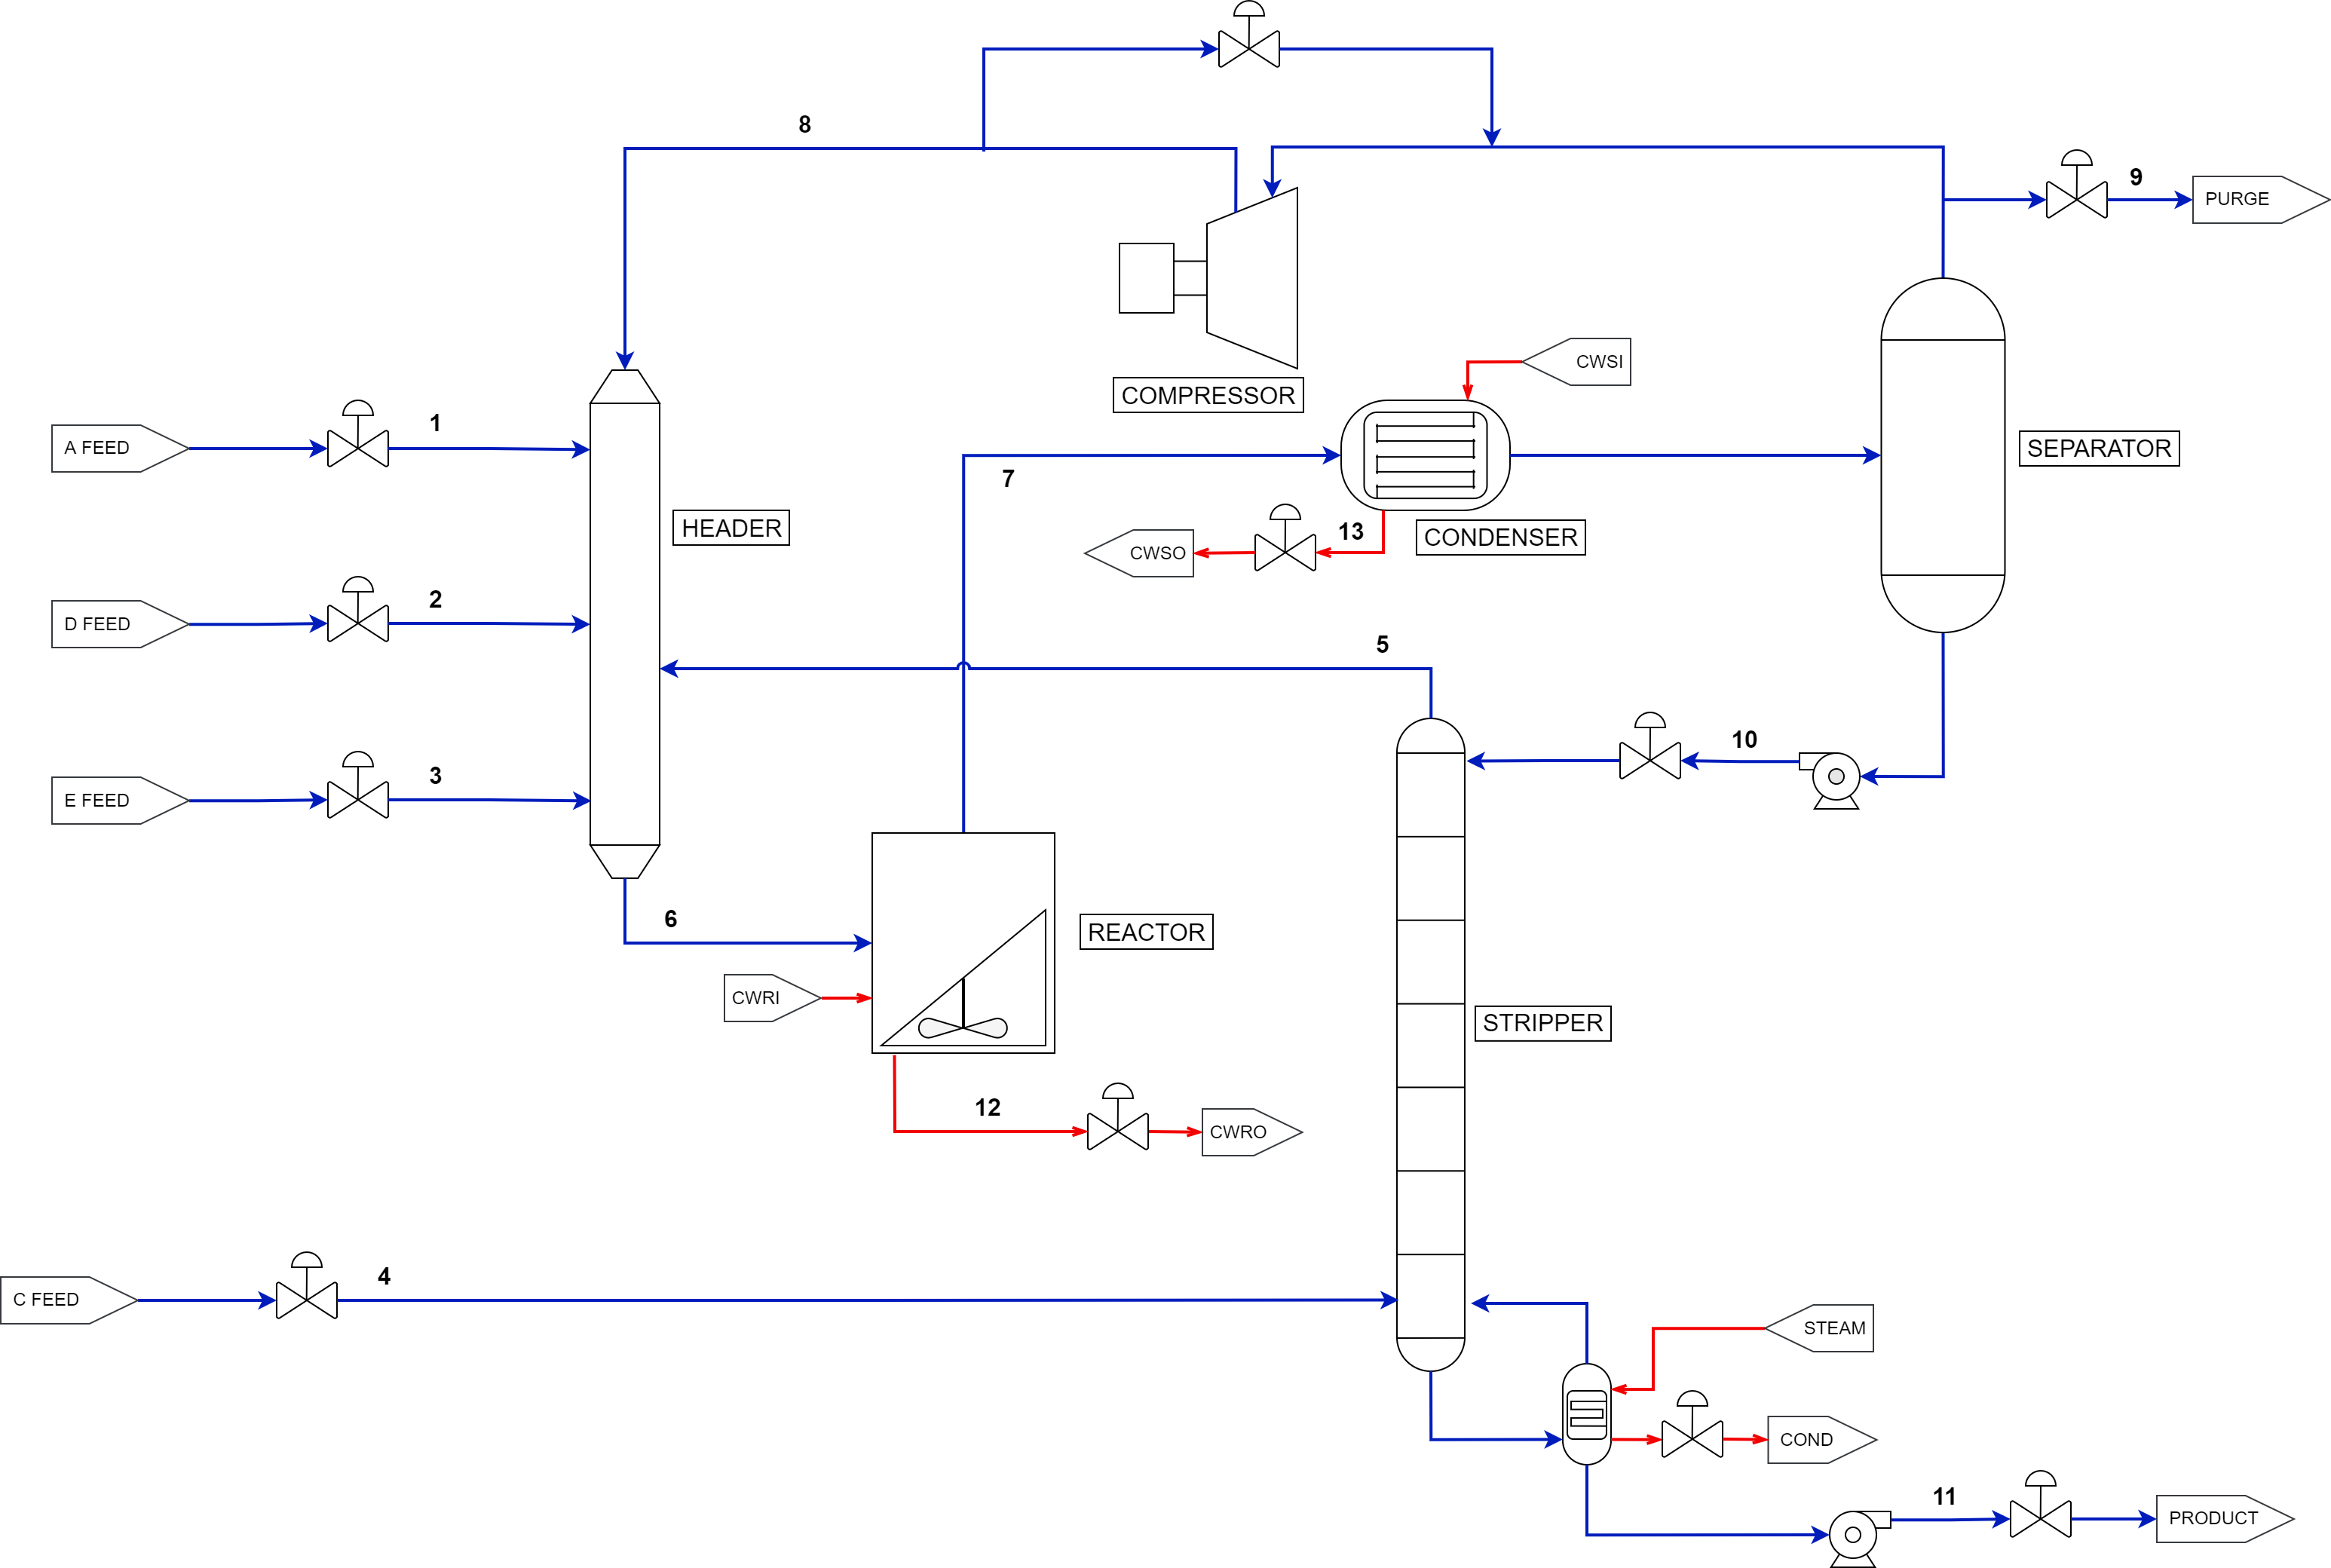

In terms of the user interface, the TE process presents 41 measurable variables with noise and delay and 12 first-order dynamics actuators that allow for external interaction with the system. The process allows the activation of 20 types of disturbances at any point during the simulation. These can work as the faults to be detected by the monitoring system. The disturbances represent step changes, drifts, random noise, and component malfunctions in the supply conditions, cooling streams, and actuators of the plant.

**[ADD DATASET FAULTS DESCRIPTION]**

In [ ]:
# Data generation
class tennessee_dataset():
    def __init__(self, train_path, test_path):

        self.data_train = pd.read_csv(train_path)
        self.data_train_np = self.data_train.values

        # Normalize and plot train data
        self.scaler = StandardScaler()

        self.Data_train_nolabel = self.scaler.fit_transform(self.data_train_np[:,0:-1])
        self.label_train = self.data_train_np[:,-1]
        self.label_train = self.label_train.reshape((len(self.label_train), 1))
        self.Data_train = np.concatenate((self.Data_train_nolabel, self.label_train), axis=1)
        self.Data_train_df = pd.DataFrame(self.Data_train)
        self.Data_train_df.columns = self.data_train.columns



        self.data_test = pd.read_csv(test_path)
        self.data_test_np = self.data_test.values
        # Normalize and test data
        self.Data_test_nolabel = self.scaler.transform(self.data_test_np[:,0:52])
        self.label_test = self.data_test_np[:,52]
        self.label_test = self.label_test.reshape((len(self.label_test), 1))
        self.Data_test = np.concatenate((self.Data_test_nolabel, self.label_test), axis=1)
        self.Data_test_df = pd.DataFrame(self.Data_test)
        self.Data_test_df.columns = self.data_test.columns

    def get_train_dataset(self):
        train_tensor = torch.tensor(self.Data_train_nolabel, dtype=torch.float32)
        train_dataset = TensorDataset(train_tensor)

        return train_dataset

    def get_test_dataset(self):
        test_tensor = torch.tensor(self.Data_test_nolabel, dtype=torch.float32)
        test_dataset = TensorDataset(test_tensor)

        return test_dataset

    def plot_data(self):

        x_axis_train = np.linspace(0, len(self.data_train), len(self.data_train))
        plt.plot(x_axis_train, self.Data_train[:,0:2])
        plt.plot(x_axis_train, self.Data_train[:,2], color='paleturquoise')
        plt.title("Data_train")
        plt.legend(labels=["x1","x2","x3"])
        plt.show()


train_path = 'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/train/d00.csv'

test_path = 'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d01.csv'

ds = tennessee_dataset(train_path, test_path)

## Exercise: statisical anomaly detection

Now that you know about the Tennessee Eastman problem, apply the same knowledge as in the warm-up exercise to do anomaly detection on this dataset  

Note: take into account that, this time, the data is multidimensional. One simple approach here is to apply the single variable random distribution to each feature of the dataset, and compound their effect into a single probability:

$p_{\text{XMEAS}(1)} · p_{\text{XMEAS}(2)} · ... · p_{\text{XMEAS}(22)} $

Take into account that this approach is a simplification and assumes each feature is statisticallly independent from each other. Later we will try to improve this.

In [ ]:
# ============= Start of your code ============= #


# =============  End of your code  ============= #

## Exercise: Multivariate statistical anomaly detection

Let's try to improve the previous approach by not assuming statistical independency between variables. For this we will use ....


Apply the Mahalanobis distance.

<font color='blue'>
Now it is your turn. Obtain a threshold of maximum Mahalanobis distance and test it on our test set. After this compare the performance with the simple statistical approach before. Has it improved?
</font>

In [ ]:
# ============= Start of your code ============= #


# =============  End of your code  ============= #

## Optional Exercise: do PCA without the sklearn PCA class

Use only algebraic operations with numpy and Singular Value Decomposition

## Exercise: Dimensionality reduction applied to anomaly detection

Dimensionality reduction is a technique that helps handling datasets with a large number of features by projecting them into a lower dimensional space, but retaining the higher amount of information as possible. To apply this to the anomaly detection problem, we follow the next steps:

* The PCA object is fitted using normal operation data only.
* For new instances to be evaluated we can try to reconstruct the original value from the PCA-projected space. Comparing the reconstruction with the original value gives us a measure of how well did PCA manage to retain information after the projection.
* If the reconstruction error is high, that means the PCA object was not used to that type of instance we input. Since PCA is fitted with normal operation data, it will struggle reconstructing anomalous data.
* A threshold will determine how large has the threshold needs to be to consider it an anomaly. To this, and being strict with the guidelines that we only use normal operation data, a typical practice is to set up the threshold such that it detects as normal a specific percentage of the training set, i.e. 99 %.

You can get the reconstruction error using the following formula:

PUT SPE FORMULA HERE

<font color='blue'>
Now it is your turn. Apply PCA to the dataset and obtain a threshold that correctly predicts as normal 99 % of the dataset.
</font>

In [ ]:
# ============= Start of your code ============= #


# =============  End of your code  ============= #

## Optional Exercise: Time series (time window)

Build windows lumping several delayed instances.

## Exercise: Neural networks applied to anomaly detection

### Introduction

As you know, neural networks are usually trained in a supervised manner. To be able to use them in a semisupervised problem, we cannot use the typical feedforward neural network. Fo this, the self-associative neural networks, also called autoencoders, come to help. Their name is self-explanatory: the goal of autoencorders is to try to reproduce the input in the output of the neural network. This may look like a trivial task but the trick here is that there is a bottleneck in the architecture of the network that causes a loss of information.

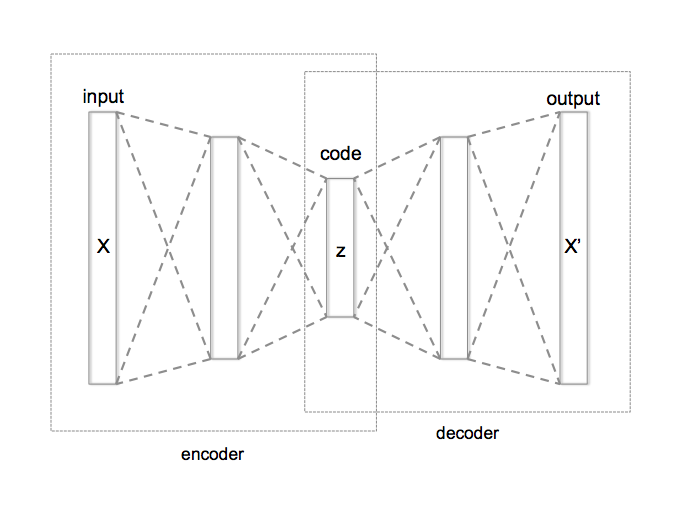


The training phase tries to make the reconstruction with the lowest possible loss despite the bottleneck. This way it is able to find the most important features and discard noise that is useless to reconstruct the input. Its usefulness in anomaly detection comes with that, if trained with normal operation data and learns to identify and reconstruct it correctly, when a abnormal event occurs, the reconstruction will show an important bias compared with nomal operation data.

Therefore, they do not use labels to train the network. However, we need to know that all the instances fed during training belong to the same class (usually the *normal operation* class), therefore the *semisupervised* surname of it.

Below you can find an implementation of a simple autoencoder in Pytorch, composed by two submodels, the encoder and the decoder:

In [ ]:
# MAKE IT ONLY ONE LAYER FOR ENCODER AND DECODER EACH

"""
Implementation of an autoencoder in PyTorch

input_dim : int
  number of features of the dataset to be input to the first layer of the
  autoencoder.
n_neurons: list
  Sequence of integers that represent the number of neurons of each layer.
latent_dim: int
  Size of the latent dimension, which is the output of the encoder and the
  input of the decoder submodels.
"""

import torch.nn as nn


class Encoder(nn.Module):

    def __init__(self, input_dim, n_neurons):
        super(Encoder, self).__init__()
        self.model = nn.Sequential()
        # Loop through layers
        for i in range(len(n_neurons)):
            if i == 0:
                n_in = input_dim
            else:
                n_in = n_neurons[i - 1]
            n_out = n_neurons[i]
            self.model.add_module(f'enc{i + 1}', nn.Linear(n_in, n_out))
            self.model.add_module(f'enc{i + 1}_relu', nn.ReLU())

    def forward(self, x):
        return self.model(x)


class Decoder(nn.Module):

    def __init__(self, latent_dim, n_neurons):
        super(Decoder, self).__init__()
        self.model = nn.Sequential()
        # Loop through layers
        for i in range(len(n_neurons)):
            if i == 0:
                n_in = latent_dim
            else:
                n_in = n_neurons[i - 1]
            n_out = n_neurons[i]
            self.model.add_module(f'dec{i + 1}', nn.Linear(n_in, n_out))
            self.model.add_module(f'dec{i + 1}_relu', nn.ReLU())

    def forward(self, z):
        return self.model(z)


class AEModel(nn.Module):
    """ Implement an autoencoder in PyTorch. """
    def __init__(self, input_dim, n_neurons):
        # input_dim = 50 for TE detection without windows
        super(AEModel, self).__init__()
        # Separate n_neuron list in two parts
        n_half_layers = len(n_neurons) // 2
        encoder_neurons = n_neurons[:n_half_layers]
        decoder_neurons = n_neurons[n_half_layers:]
        # Build encoder-decoder system
        self.encoder = Encoder(input_dim=input_dim,
                               n_neurons=encoder_neurons)
        self.decoder = Decoder(latent_dim=encoder_neurons[-1],
                               n_neurons=decoder_neurons)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

<font color='blue'> In this exercise, you will need to create an instance of this autoencoder with an adequate number of neurons, set up the optimizer, train it, and compare the performance with the previous approaches in this notebook.
</font>

<font color='blue'>
Create the model object and prepare the optimizer here:
</font>

In [ ]:
# ============= Start of your code ============= #


# =============  End of your code  ============= #

<font color='blue'>
Perform the training here:
</font>

In [ ]:
# ============= Start of your code ============= #


# =============  End of your code  ============= #

<font color='blue'>
Tune a threshold for the anomaly detection task and obtain the accuracy for the training set (should be 99 %)
</font>

In [ ]:
# ============= Start of your code ============= #


# =============  End of your code  ============= #

<font color='blue'>
Evaluate the performance on the test set here and compare with the previous approaches
</font>

In [ ]:
# ============= Start of your code ============= #


# =============  End of your code  ============= #